In [1]:
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

In [3]:
library(tidyverse)
library(chromVAR)
library(motifmatchr)
library(Matrix)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg38)
library(pheatmap)
library(TFBSTools)
library(JASPAR2018)
library(BiocParallel)
library(purrr)
register(MulticoreParam(8))
set.seed(2019)


In [4]:
setwd("/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/")

# chromVAR analysis 1 - chromVAR + Jaspar 2018 motifs
**Inputs**
1. *Peaks*: These are peaks centered at summit with uniform width of 500 bp as recommended by chromVAR. This versin only works with peaks that are in the promoter region. `/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed`. First 3 columns are standard bed, the 4th column is peak intensity as calculated from MACS2.
2. *Annovation*: Jaspar 2018 motifs

In [5]:
samplesheet <- read.csv('samplesheet2.csv', stringsAsFactors = F)

In [15]:
# Peaks
peak.file <- "/c/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap_promoterOnly.bed"
peaks <- getPeaks(peak.file, sort_peaks = T)

Warning message in getPeaks(peak.file, sort_peaks = T):
“Peaks are overlapping!After getting peak counts, peaks can be reduced to non-overlapping set using filterPeaks function”Warning message in getPeaks(peak.file, sort_peaks = T):
“Peaks are not equal width!Use resize(peaks, width = x, fix = "center") to make peaks equal in size, where x is the desired size of the peaks)”Peaks sorted


In [16]:
peaks <- resize(peaks, width = 500, fix = "center")

In [17]:
peaks

GRanges object with 15629 ranges and 0 metadata columns:
          seqnames              ranges strand
             <Rle>           <IRanges>  <Rle>
      [1]     chr1       959089-959588      *
      [2]     chr1       959089-959588      *
      [3]     chr1       960231-960730      *
      [4]     chr1       960231-960730      *
      [5]     chr1       966292-966791      *
      ...      ...                 ...    ...
  [15625]     chrX 154762481-154762980      *
  [15626]     chrX 155026718-155027217      *
  [15627]     chrX 155071178-155071677      *
  [15628]     chrX 155071178-155071677      *
  [15629]     chrX 155264176-155264675      *
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [22]:
my_counts_matrix <- read.table("diffbind_consensu_min2overlap_promoterOnly_counts.txt", header = F, 
                              col.names=c("A1","A2","A3","A4","A5","A6","A7","A8","A9","A10","A11","A12")) %>% as.matrix

In [24]:
depth <- my_counts_matrix %>% apply(2, sum)
colData <- samplesheet %>% column_to_rownames('SampleID')
colData <- colData %>% add_column(depth) # add read depth per sample

In [25]:
fragment_counts <- SummarizedExperiment(assays = list(counts = my_counts_matrix),
                                        rowRanges = peaks, colData = colData)

In [26]:
fragment_counts

class: RangedSummarizedExperiment 
dim: 15629 12 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(0):
colnames(12): A1 A2 ... A11 A12
colData names(11): Tissue Factor ... Peakcaller depth

In [27]:
fragment_counts.addGC <- addGCBias(fragment_counts, genome = BSgenome.Hsapiens.UCSC.hg38)

In [28]:
# each peak must have at least 10 reads across all 12 samples to be included
fragment_counts.filtered <- filterPeaks(fragment_counts.addGC, min_fragments_per_peak = 10, 
                                       non_overlapping = T)

In [29]:
fragment_counts.filtered

class: RangedSummarizedExperiment 
dim: 13905 12 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(1): bias
colnames(12): A1 A2 ... A11 A12
colData names(11): Tissue Factor ... Peakcaller depth

In [30]:
counts(fragment_counts.filtered) %>% head

6 x 12 Matrix of class "dgeMatrix"
      A1  A2 A3  A4  A5  A6 A7  A8  A9 A10 A11 A12
[1,]  66  50 73  62  84  53 49  64 141  73  93  97
[2,]  61  44 61  88  57  71 44  60 124  76  61  78
[3,]  63  81 75  64  64  77 35  88 125  90  47  38
[4,]  69  36 78  49  61  60 37  50  96  66  47  83
[5,] 106 107 71 104 124 114 81 149 219 154 184 149
[6,]  76  97 67  65  88 102 62  72 134  98  73  46

#### Annotations

In [31]:
# get jaspar 2018 motifs
opts <- list()
opts[["species"]] <- "Homo sapiens"
jaspar_motifs <- getMatrixSet(JASPAR2018, opts)

In [32]:
# get motif matches
motif_ix <- matchMotifs(jaspar_motifs, fragment_counts.filtered, genome = BSgenome.Hsapiens.UCSC.hg38)

In [33]:
motif_ix

class: RangedSummarizedExperiment 
dim: 13905 452 
metadata(0):
assays(1): motifMatches
rownames: NULL
rowData names(1): bias
colnames(452): MA0025.1 MA0030.1 ... MA1420.1 MA1421.1
colData names(1): name

In [34]:
#120 hit list
hitlist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/HS_td-VStd+_td-VSdox120.csv', header = F, stringsAsFactors = F) %>% pull
#TF list
tflist <- read.csv('/c/groups//sanjana_lab/cdai/TFscreen/TFlist.csv', stringsAsFactors = F, col.names='gene_name') %>% pull(var = gene_name)

In [35]:
motif_lookup <- TFBSTools::name(jaspar_motifs) %>% data.frame(stringsAsFactors = F) %>% rownames_to_column("motif") %>% 
                mutate_at(vars(.), list(gene_name = toupper)) %>% select(motif, gene_name)

mystrfunc <- function(stringA, target) {
    # string A is a possible gene name, scalar
    # target is a vector of proper gene names
    # match if any target is a substring in string A, if so return True
    stringA <- rep(stringA, length(target))
    test <- unlist(map2(stringA, target, ~ str_detect(.x, .y)))
    return(any(test))
}

#motif_lookup <- motif_lookup  %>% mutate(is_hit = map(gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No"))) %>%
                 #mutate(is_tf = map(gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No"))) 

is_hit <- map(motif_lookup$gene_name, ~ if_else(mystrfunc(.x, hitlist), "Yes", "No")) %>% unlist
is_tf <- map(motif_lookup$gene_name, ~ if_else(mystrfunc(.x, tflist), "Yes", "No")) %>% unlist

motif_lookup <- motif_lookup %>% add_column(is_hit = is_hit, is_tf = is_tf)

#### Deviations

In [36]:
# computing deviations
dev <- computeDeviations(object = fragment_counts.filtered, annotations = motif_ix)

In [38]:
dev

class: chromVARDeviations 
dim: 452 12 
metadata(0):
assays(2): deviations z
rownames(452): MA0025.1 MA0030.1 ... MA1420.1 MA1421.1
rowData names(3): name fractionMatches fractionBackgroundOverlap
colnames(12): A1 A2 ... A11 A12
colData names(11): Tissue Factor ... Peakcaller depth

In [39]:
dev.scores <- deviationScores(dev) %>% as.data.frame %>% rownames_to_column('motif')

##### construct motif gene name lookup

In [40]:
dev.scores <- left_join(dev.scores, motif_lookup, by = 'motif')

In [41]:
dev.scores %>% filter(str_detect(gene_name, 'IN'))

motif,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name,is_hit,is_tf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
MA0155.1,-0.08460755,0.5341702,-0.1788859,-1.598946,1.0290762,0.3490176,-0.51267618,0.2334468,1.720059,1.0472476,-0.7280356,-0.9937419,INSM1,Yes,Yes
MA0131.2,-1.08723064,-0.2850653,1.1886528,0.748865,-0.5320344,0.5346638,-0.01644776,-0.6246651,-2.288500,0.1141245,0.8793434,0.7868002,HINFP,No,No


In [44]:
dev.scores %>% head

motif,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name,is_hit,is_tf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
MA0025.1,0.5118651,-0.4443237,-0.25026807,0.2320888,-1.2103325,-1.1007895,-0.6321204,-0.5458321,-1.3336139,1.5173081,0.28725890,1.4660796,NFIL3,No,Yes
MA0030.1,0.1810515,-0.5117005,-1.20663844,1.0594492,0.1916004,-0.3078999,-0.7871249,0.2095467,-1.6156866,0.8347467,0.69745067,0.5236757,FOXF2,No,Yes
MA0031.1,0.8033230,1.3316032,-0.65273966,1.3099499,1.8307113,0.2987074,0.7122628,0.2241653,-1.2582522,-0.1218474,-0.84977952,-0.7967040,FOXD1,No,Yes
MA0051.1,-0.9433333,-0.3382523,-0.59062402,-0.4588813,-0.4373785,-0.3184603,-0.2816591,-0.5685274,-0.2252398,0.4310413,0.76424291,1.0319925,IRF2,No,Yes
MA0056.1,-1.3614454,0.7448137,0.27461627,0.2890768,0.5248078,-0.2735984,0.3417060,0.1347914,-0.3793298,0.4783358,-0.07935538,-0.1629806,MZF1,No,Yes
MA0057.1,0.1777844,0.5721168,-0.05273389,0.6585407,2.3285381,1.7334211,1.0691472,1.6257569,0.7647744,-0.1548250,-1.94004257,-1.9023953,MZF1(VAR.2),No,Yes


In [45]:
str(dev.scores)

'data.frame':	452 obs. of  16 variables:
 $ motif    : chr  "MA0025.1" "MA0030.1" "MA0031.1" "MA0051.1" ...
 $ A1       : num  0.512 0.181 0.803 -0.943 -1.361 ...
 $ A2       : num  -0.444 -0.512 1.332 -0.338 0.745 ...
 $ A3       : num  -0.25 -1.207 -0.653 -0.591 0.275 ...
 $ A4       : num  0.232 1.059 1.31 -0.459 0.289 ...
 $ A5       : num  -1.21 0.192 1.831 -0.437 0.525 ...
 $ A6       : num  -1.101 -0.308 0.299 -0.318 -0.274 ...
 $ A7       : num  -0.632 -0.787 0.712 -0.282 0.342 ...
 $ A8       : num  -0.546 0.21 0.224 -0.569 0.135 ...
 $ A9       : num  -1.334 -1.616 -1.258 -0.225 -0.379 ...
 $ A10      : num  1.517 0.835 -0.122 0.431 0.478 ...
 $ A11      : num  0.2873 0.6975 -0.8498 0.7642 -0.0794 ...
 $ A12      : num  1.466 0.524 -0.797 1.032 -0.163 ...
 $ gene_name: chr  "NFIL3" "FOXF2" "FOXD1" "IRF2" ...
 $ is_hit   : chr  "No" "No" "No" "No" ...
 $ is_tf    : chr  "Yes" "Yes" "Yes" "Yes" ...


In [46]:
dev.scores %>% select(motif, gene_name, is_hit, is_tf, A1:A12) %>% write.table("chromVAR_jaspar2018_zScore_promoterOnly.csv", sep = ",", quote = F, row.names = F, col.names = T)

In [47]:
jaspar_motifs$MA0698.1

An object of class PFMatrix
ID: MA0698.1
Name: ZBTB18
Matrix Class: C2H2 zinc finger factors
strand: +
Tags: 
$comment
[1] "Data is from Taipale HTSELEX DBD (2013)"

$family
[1] "More than 3 adjacent zinc finger factors"

$medline
[1] "9756912"

$source
[1] "23332764"

$tax_group
[1] "vertebrates"

$type
[1] "HT-SELEX"

$collection
[1] "CORE"

$species
          9606 
"Homo sapiens" 

$acc
[1] "Q99592"

Background: 
   A    C    G    T 
0.25 0.25 0.25 0.25 
Matrix: 
  [,1] [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11] [,12] [,13]
A 3561 7064  1177  3618    21 13670     3 13670    14     3    48   210  1725
C 4188  753  1937 13670 13670     5   245  1048    15     1   314   177  4042
G 2499 2535  5212  1899     3    33 13670   278    94 13670    36  5530  3876
T 3423 3319 13670    60     8   206     6   297 13670     1 13670  8140  4027

---

## Clustering based on correlation

In [48]:
sample_cor <- getSampleCorrelation(dev)

In [49]:
library(repr)
options(repr.plot.width=6, repr.plot.height=5)

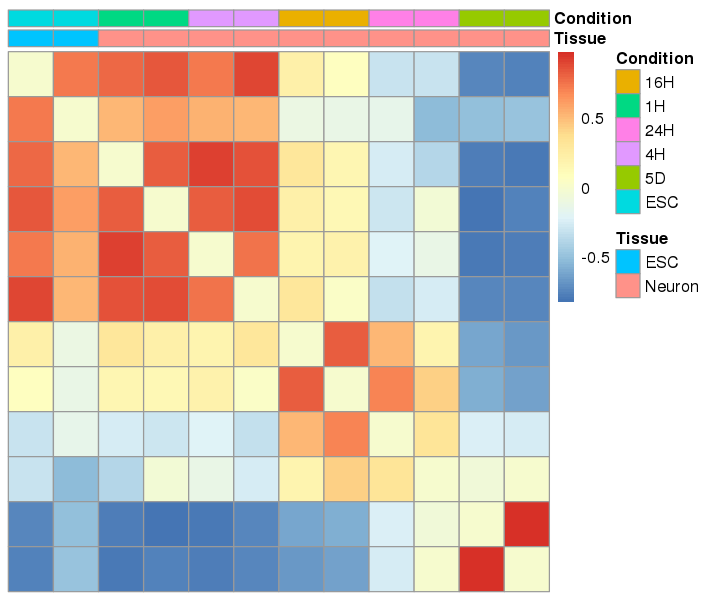

In [50]:
pheatmap(as.dist(sample_cor), annotation = data.frame(colData(dev)[,c(1,3)]), clustering_distance_rows = as.dist(1-sample_cor), clustering_distance_cols = as.dist(1-sample_cor),
        cluster_rows = F, show_rownames = T, cluster_cols = F, show_colnames = T)

## Variability

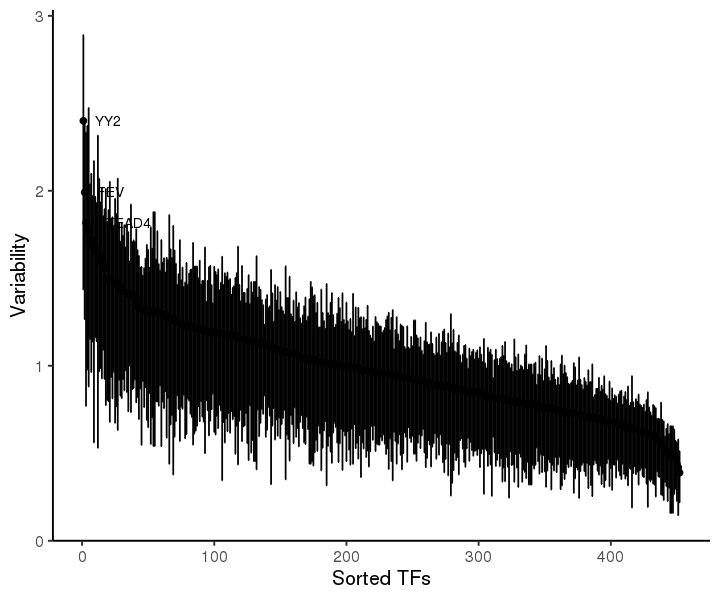

In [51]:
variability <- computeVariability(dev)
plotVariability(variability, use_plotly = FALSE)

## Sample similarity

In [58]:
tsne_results <- deviationsTsne(dev, threshold = 1.5, perplexity = 3, shiny = FALSE, what = "annotations")

In [59]:
tsne_results <- tsne_results %>% rownames_to_column("motif") %>% left_join(y = motif_lookup, by = "motif")

In [60]:
tsne_results %>% head

motif,Dim1,Dim2,gene_name,is_hit,is_tf
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
MA0475.2,30.79712,-33.37928,FLI1,No,Yes
MA0080.4,24.06697,-37.10481,SPI1,No,Yes
MA0141.3,-83.64603,89.66218,ESRRB,No,Yes
MA0748.1,37.94412,-46.75745,YY2,No,No
MA0754.1,47.13377,-40.79756,CUX1,No,No
MA0757.1,33.90901,-43.61793,ONECUT3,No,Yes


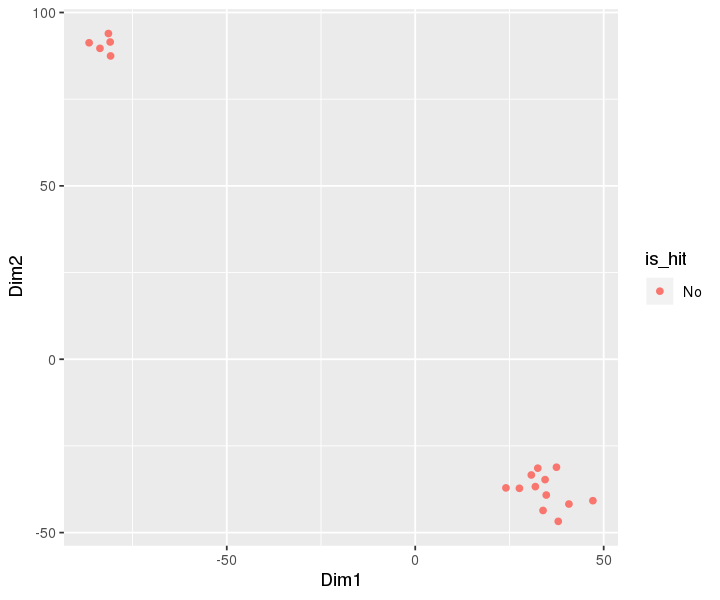

In [61]:
tsne_results %>% ggplot() + geom_point(aes(x=Dim1, y=Dim2, color=is_hit))

In [64]:
tsne_results2 <- deviationsTsne(dev, threshold = 1.5, perplexity = 3, shiny = FALSE)

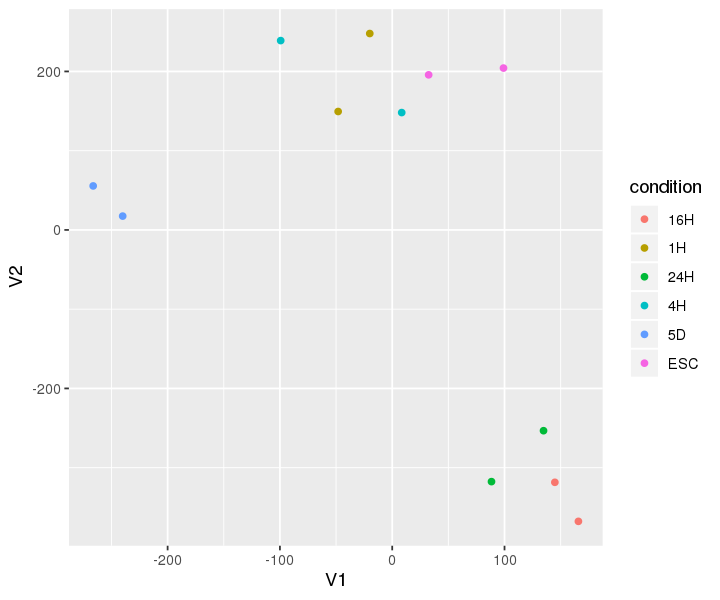

In [65]:
tsne_results2  %>% as.data.frame %>% rownames_to_column("sample") %>% add_column(condition = colData(dev)$Condition) %>% ggplot() + geom_point(aes(x=V1, y=V2, color=condition))

In [66]:
dev.scores %>% filter(gene_name == 'ZBTB18')

motif,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name,is_hit,is_tf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
MA0698.1,0.9949458,0.717767,0.5174323,0.5375931,0.4864306,0.4749739,1.65787,-0.2284104,0.2228484,-0.884163,-0.4569733,-1.508741,ZBTB18,Yes,Yes


In [84]:
dev.scores %>% head(10)

motif,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,gene_name,is_hit,is_tf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
MA0025.1,0.5118651,-0.4443237,-0.25026807,0.2320888,-1.21033247,-1.10078948,-0.63212038,-0.5458321,-1.3336139,1.51730810,0.28725890,1.4660796,NFIL3,No,Yes
MA0030.1,0.1810515,-0.5117005,-1.20663844,1.0594492,0.19160043,-0.30789989,-0.78712492,0.2095467,-1.6156866,0.83474666,0.69745067,0.5236757,FOXF2,No,Yes
MA0031.1,0.8033230,1.3316032,-0.65273966,1.3099499,1.83071129,0.29870737,0.71226285,0.2241653,-1.2582522,-0.12184736,-0.84977952,-0.7967040,FOXD1,No,Yes
MA0051.1,-0.9433333,-0.3382523,-0.59062402,-0.4588813,-0.43737854,-0.31846034,-0.28165910,-0.5685274,-0.2252398,0.43104126,0.76424291,1.0319925,IRF2,No,Yes
MA0056.1,-1.3614454,0.7448137,0.27461627,0.2890768,0.52480778,-0.27359835,0.34170599,0.1347914,-0.3793298,0.47833576,-0.07935538,-0.1629806,MZF1,No,Yes
MA0057.1,0.1777844,0.5721168,-0.05273389,0.6585407,2.32853808,1.73342112,1.06914717,1.6257569,0.7647744,-0.15482497,-1.94004257,-1.9023953,MZF1(VAR.2),No,Yes
MA0059.1,-0.6513508,2.5961858,0.78990274,0.6715461,0.02862328,-0.01092443,-1.29922890,0.4430171,-0.6750958,0.22568708,-0.53363567,-0.2664776,MAX::MYC,No,Yes
MA0066.1,-0.1272087,0.1755642,1.17275674,0.3329182,0.32424370,-0.27870152,-1.90693371,-0.5813684,-0.2124453,-1.31398454,-0.01406583,0.9050653,PPARG,No,Yes
MA0069.1,-0.2984246,0.6590049,-0.70479409,-1.1410194,-0.74951294,0.31884547,-0.08312229,-0.8959771,1.0341251,-0.31205831,0.08711617,0.4679573,PAX6,No,Yes


### Binding site accessibility for Hit TFs

In [76]:
fragment_counts.filtered@rowRanges

GRanges object with 13905 ranges and 1 metadata column:
          seqnames              ranges strand |      bias
             <Rle>           <IRanges>  <Rle> | <numeric>
      [1]     chr1       959089-959588      * |     0.744
      [2]     chr1       960231-960730      * |     0.736
      [3]     chr1       966292-966791      * |     0.716
      [4]     chr1       999112-999611      * |      0.77
      [5]     chr1     1000099-1000598      * |     0.764
      ...      ...                 ...    ... .       ...
  [13901]     chrX 154547041-154547540      * |     0.734
  [13902]     chrX 154762481-154762980      * |     0.672
  [13903]     chrX 155026718-155027217      * |      0.72
  [13904]     chrX 155071178-155071677      * |     0.738
  [13905]     chrX 155264176-155264675      * |     0.632
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

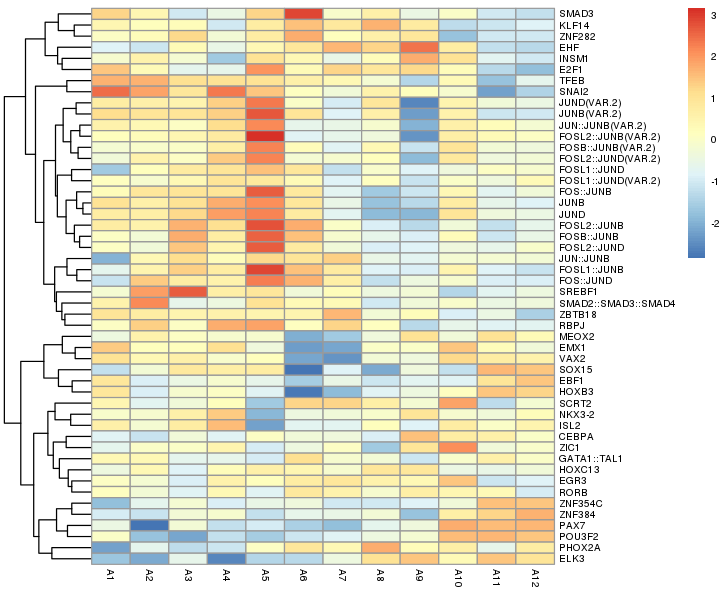

In [77]:
dev.scores %>%  filter(is_hit == "Yes") %>% select(gene_name, A1:A12)  %>% column_to_rownames('gene_name')  %>%
                        pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, fontsize=6)

### show all TF binding sites

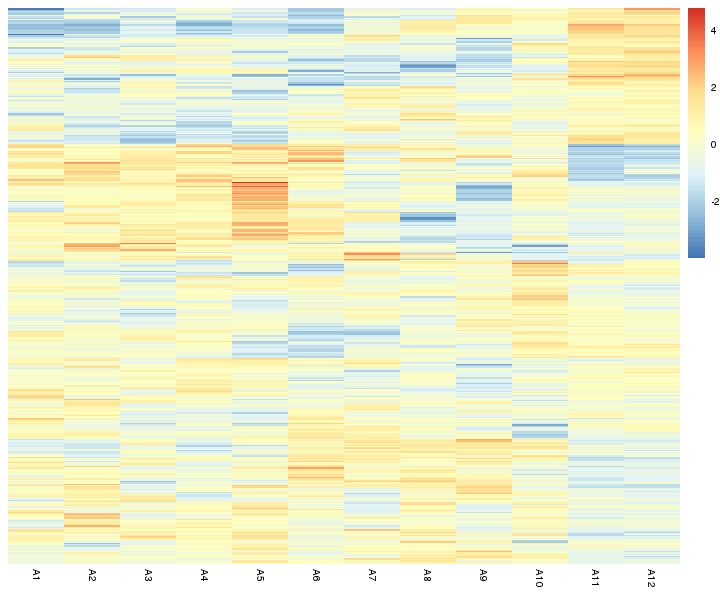

In [85]:
dev.scores %>%  filter(is_tf == "Yes") %>% select(gene_name, A1:A12)  %>% column_to_rownames('gene_name')  %>%
                        pheatmap(cluster_rows = T, show_rownames = F, cluster_cols = F, show_colnames=T, fontsize=6, treeheight_row=0)

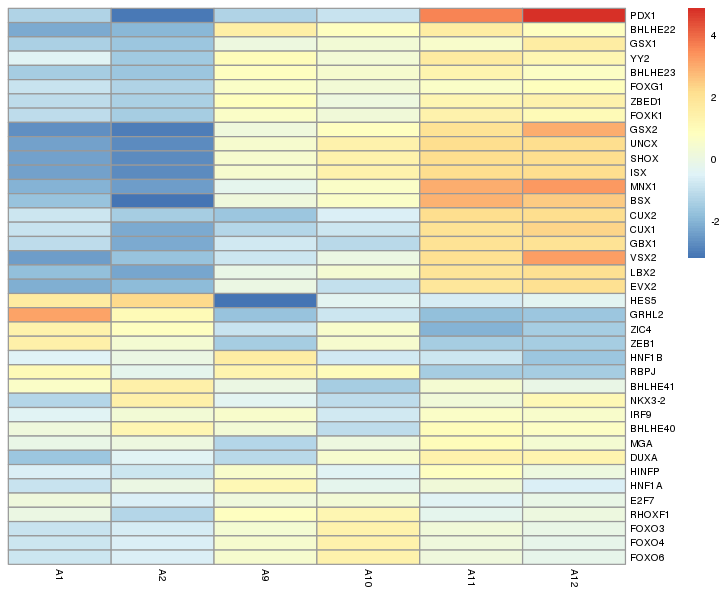

In [705]:
dev.scores %>%  filter(is_tf == "No") %>% select(gene_name, A1:A2,A9:A12)  %>% column_to_rownames('gene_name')  %>%
                        pheatmap(cluster_rows = T, show_rownames = T, cluster_cols = F, show_colnames=T, fontsize=6, treeheight_row=0)

## Match hit gene motifs with promoter region sequences

In [870]:
motif_lookup %>% filter(gene_name == 'ZBTB18')

motif,gene_name,is_hit,is_tf
<chr>,<chr>,<chr>,<chr>
MA0698.1,ZBTB18,Yes,Yes


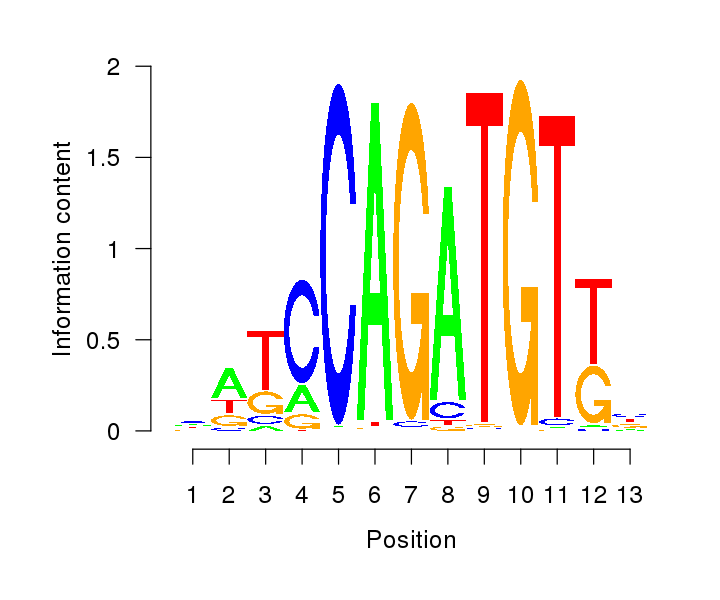

In [947]:
#sequence logo for ZBTB18
mx <- toPWM(jaspar_motifs$MA0698.1@profileMatrix, "prob" )
seqLogo(pwm = mx)

## Find TF targets

#### Method 1 - Use meme suites - TGene

1. Get jaspar motifs (done in chromvar steps)
2. Get motif match matrix (done in chromvar steps)
3. From motif match matrix, subset only hit genes
4. Get promoter region bed
5. use motifmatchr to match hit TF motifs and promoter region
6. For each TF motif, get a list of ranges (peaks) that has a match to that motif

In [987]:
# get annotated promoter region bed
promoter_region <- read.table("Protein_coding_gene_promoters.bed", header = F, stringsAsFactors = F, 
                              col.names = c("seqname","start","end","gene_id","gene_name","strand")) %>% 
                    dplyr::select(seqname, start, end, strand, gene_id, gene_name)

In [989]:
# convert to GRanges object
promoter_region <- GenomicRanges::makeGRangesFromDataFrame(promoter_region, keep.extra.columns = T)

In [998]:
opts <- list()
opts[["species"]] <- "Homo sapiens"
jaspar_motifs <- getMatrixSet(JASPAR2018, opts)

# get motif matche matrix
promoter_motif_ix <- matchMotifs(jaspar_motifs, promoter_region, genome = BSgenome.Hsapiens.UCSC.hg38)

In [999]:
# motif IDs for hit TF
hit_motif_id <- motif_lookup %>% filter(is_hit == "Yes") %>% pull(motif)

# hit TF motif match matrix (with promoters)
hit_motif_ix <- promoter_motif_ix[, hit_motif_id]

# hit motif matches (with promoters)
hit_motif_matches <- motifMatches(hit_motif_ix)

In [1000]:
which(hit_motif_matches[, 'MA0698.1']) %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      4    5020   10164   10049   15156   19959 

In [1014]:
which(hit_motif_matches[, 'MA0698.1']) %>% length

[1] 6764

In [1013]:
# genes (with promoter region sequence) matching ZBTB18 motif. Found 6764. How do we get a 
zbx<- promoter_region[which(hit_motif_matches[, 'MA0698.1'])] 

In [1015]:
zbx

GRanges object with 6764 ranges and 2 metadata columns:
         seqnames            ranges strand |            gene_id   gene_name
            <Rle>         <IRanges>  <Rle> |        <character> <character>
     [1]     chr1     921928-924428      + | ENSG00000187634.12      SAMD11
     [2]     chr1   1213653-1216153      - | ENSG00000186827.11     TNFRSF4
     [3]     chr1   1309109-1311609      - | ENSG00000131584.19       ACAP3
     [4]     chr1   1324191-1326691      - | ENSG00000127054.20      INTS11
     [5]     chr1   1322756-1325256      + |  ENSG00000224051.7        CPTP
     ...      ...               ...    ... .                ...         ...
  [6760]     chrY 19076916-19079416      - |  ENSG00000286265.1  AC007244.1
  [6761]     chrY 22095507-22098007      - | ENSG00000169807.10        PRY2
  [6762]     chrY 22488397-22490897      + | ENSG00000169789.10         PRY
  [6763]     chrY 24047519-24050019      - |  ENSG00000172352.5       CDY1B
  [6764]     chrY 25620162-25622

What next?

intersect these 6764 genes with peak file, so we get a set of ZBTB18 hits that intersect with frag

In [1019]:
filtered.peaks <- fragment_counts.filtered@rowRanges

In [1026]:
filtered.peaks %>% as.data.frame %>% write.table("y_peaks.bed", sep = "\t", row.names = F, col.names = F, quote = F)

In [1027]:
zbx %>% as.data.frame %>% write.table("x_zbx.bed", sep = "\t", row.names = F, col.names = F, quote = F)

In [1023]:
GenomicRanges::intersect(x = filtered.peaks, y = zbx, ignore.strand = T)

GRanges object with 4637 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr1     1324531-1325030      *
     [2]     chr1     1399206-1399705      *
     [3]     chr1     1407077-1407576      *
     [4]     chr1     1511791-1512290      *
     [5]     chr1     1540579-1541078      *
     ...      ...                 ...    ...
  [4633]     chrX 154444375-154444641      *
  [4634]     chrX 154478789-154479288      *
  [4635]     chrX 154490549-154491048      *
  [4636]     chrX 154547072-154547540      *
  [4637]     chrX 155026718-155027217      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [1020]:
filtered.peaks

GRanges object with 116105 ranges and 1 metadata column:
           seqnames              ranges strand |      bias
              <Rle>           <IRanges>  <Rle> | <numeric>
       [1]     chr1       629662-630161      * |     0.424
       [2]     chr1       633789-634288      * |     0.436
       [3]     chr1       778488-778987      * |     0.642
       [4]     chr1       827266-827765      * |     0.694
       [5]     chr1       869628-870127      * |     0.714
       ...      ...                 ...    ... .       ...
  [116101]     chrX 155612617-155613116      * |      0.65
  [116102]     chrY   56836920-56837419      * |     0.476
  [116103]     chrY   56848157-56848656      * |     0.478
  [116104]     chrY   56850483-56850982      * |     0.474
  [116105]     chrY   56873549-56874048      * |      0.43
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [894]:
matches <- promoter_matches[, which(rownames(colData(motif_promoter_ix)) %in% motif_hit)]

In [895]:
ix <- which(matches[, which(colnames(matches) == 'MA0698.1')])

In [897]:
promoter_region[ix]$gene_name %>% t

SAMD11,TNFRSF4,ACAP3,INTS11,CPTP,MXRA8,CCNL2,MRPL20,ATAD3C,ATAD3A,⋯,ZBED1,SRY,RPS4Y1,CDY2B,CDY2A,AC007244.1,PRY2,PRY,CDY1B,CDY1


In [867]:
motifCounts(promoter_match_scores) %>% str

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:2173757] 0 2 13 40 53 58 76 98 102 103 ...
  ..@ p       : int [1:453] 0 3349 8760 12709 19364 37453 45134 47776 51890 54270 ...
  ..@ Dim     : int [1:2] 19962 452
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:452] "MA0025.1" "MA0030.1" "MA0031.1" "MA0051.1" ...
  ..@ x       : num [1:2173757] 1 1 1 1 1 1 1 1 3 2 ...
  ..@ factors : list()


In [1057]:
zbx_target <- read.table("zbx_target.bed", header = F, stringsAsFactors = F)

In [1058]:
target <- zbx_target %>% filter(V7 %in% hitlist) %>% pull(V7) %>% unique %>% sort

In [1059]:
target %>% t

ARID1B,ASB1,CBX4,CDX4,CHD5,EGR3,ELK3,JADE3,JUND,NEUROG3,⋯,UBE2K,VAX2,ZBTB18,ZNF107,ZNF136,ZNF141,ZNF282,ZNF324,ZNF510,ZNF639


In [1064]:
zbx_target %>% head

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>
chr1,1324191,1326691,2501,-,ENSG00000127054.20,INTS11,chr1,1324531,1325030,500,*,0.758,499
chr1,1322756,1325256,2501,+,ENSG00000224051.7,CPTP,chr1,1324531,1325030,500,*,0.758,499
chr1,1398835,1401335,2501,-,ENSG00000221978.12,CCNL2,chr1,1399206,1399705,500,*,0.734,499
chr1,1406793,1409293,2501,-,ENSG00000242485.6,MRPL20,chr1,1407077,1407576,500,*,0.708,499
chr1,1510151,1512651,2501,+,ENSG00000197785.13,ATAD3A,chr1,1511791,1512290,500,*,0.710,499
chr1,1540124,1542624,2501,-,ENSG00000205090.9,TMEM240,chr1,1540579,1541078,500,*,0.760,499


In [1072]:
zbx_target %>% filter(V7 %in% target) %>% 

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<int>
chr1,6179821,6182321,2501,-,ENSG00000116254.18,CHD5,chr1,6180627,6181126,500,*,0.638,499
chr1,244046939,244049439,2501,+,ENSG00000179456.10,ZBTB18,chr1,244048178,244048677,500,*,0.762,499
chr2,70898576,70901076,2501,+,ENSG00000116035.4,VAX2,chr2,70900237,70900736,500,*,0.724,499
chr2,238424742,238427242,2501,+,ENSG00000065802.12,ASB1,chr2,238426517,238427016,500,*,0.734,499
chr3,23943286,23945786,2501,+,ENSG00000174738.13,NR1D2,chr3,23944890,23945389,500,*,0.714,499
chr3,23943286,23945786,2501,+,ENSG00000174738.13,NR1D2,chr3,23945717,23946216,500,*,0.790,69
chr3,179321031,179323531,2501,+,ENSG00000121864.10,ZNF639,chr3,179322633,179323132,500,*,0.742,499
chr4,335814,338314,2501,+,ENSG00000131127.14,ZNF141,chr4,337458,337957,500,*,0.570,499
chr4,39696109,39698609,2501,+,ENSG00000078140.14,UBE2K,chr4,39697748,39698247,500,*,0.720,499
